In [236]:
%matplotlib inline

### H3 Exploration

In [1]:
from h3 import h3
import folium
import pandas as pd
import geopandas as gp
import numpy as np

In [2]:
# Visualisation for uber H3
def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons.
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)

    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m


def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

In [ ]:
h3_address = h3.geo_to_h3(37.3615593, -122.0553238, 9) # lat, lng, hex resolution
m = visualize_hexagons([h3_address])
display(m)

## Read shipping lanes and pirate data

In [227]:
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from typing import Iterator, Union
from shapely.geometry.linestring import LineString
from shapely.geometry.multilinestring import MultiLineString
from shapely.geometry import Point
from typing import Dict, List
%matplotlib inline
# plt.rcParams['figure.figsize'] = (20, 10)

### Explore and endcode shipping routes data

In [ ]:
## drop missing values, possible encode (if picking top 10 routes), check if how the data in given column is correctly represented, explain data! longitude/latitude and what does name mean? name of boat or name of route?
gpf = gpd.read_file("../.data/global_shipping_routes.json")

# gpf.head()
# gpf.info()
# gpf.columns

# remove_na_and_low_val_count = remove_na.groupby("Name0").filter(lambda x: len(x) > 1)
# remove_na.columns
# remove_na_and_low_val_count["Name0"].value_counts()
# tester_points = linestring_to_points(gpf['geometry'][0])
# print(tester_points)

### Explore and encode pirate attack data

In [ ]:
## You need to drop missing values, encode all categorical data, drop outliers, do some sort of feature selection (picking those most influential)
pirate_csv = pd.read_csv("../.data/pirate_attacks.csv")

# pirate_csv.head()
pirate_csv.info()
pirate_csv["attack_type"].unique()
# pirate_csv.columns

### Nodes

In [235]:
## Make
def map_route_to_multilinestring(routes: List[str], df: GeoDataFrame) -> Dict[str, List[LineString]]:
    route_to_multilines = {}
    for name in routes:
        lines_in_route = df[df["Name0"]==name]["geometry"].tolist()
        route_to_multilines[name] = lines_in_route
    return route_to_multilines

def find_sum_length_of_boat_route(df: GeoDataFrame) -> Dict:
    boat_names = df["Name0"].unique()
    sum_boat_route_lengths = {}
    for name in boat_names:
        boat_route_length = df[df["Name0"] == name]["Length0"].sum()
        sum_boat_route_lengths[name] = boat_route_length
    return sum_boat_route_lengths

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7511 entries, 0 to 7510
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  7511 non-null   object 
 1   time                  1149 non-null   object 
 2   longitude             7511 non-null   float64
 3   latitude              7511 non-null   float64
 4   attack_type           7391 non-null   object 
 5   location_description  7503 non-null   object 
 6   nearest_country       7492 non-null   object 
 7   eez_country           7216 non-null   object 
 8   shore_distance        7511 non-null   float64
 9   shore_longitude       7511 non-null   float64
 10  shore_latitude        7511 non-null   float64
 11  attack_description    1173 non-null   object 
 12  vessel_name           6079 non-null   object 
 13  vessel_type           1173 non-null   object 
 14  vessel_status         6599 non-null   object 
 15  data_source          

array([nan, 'Attempted', 'Hijacked', 'Boarded', 'Boarding', 'Fired Upon',
       'Explosion', 'Detained', 'Suspicious'], dtype=object)

In [231]:
# Pirate data points
gps_points = pirate_csv[["longitude", "latitude"]]
pirate_attack_points = []
for index, row in gps_points.iterrows():
    tmp_point = Point(row["longitude"], row["latitude"])
    pirate_attack_points.append(tmp_point)

In [232]:
# top k=4 Shipping routes
tester_gpf = gpf.copy()
tester_gpf = tester_gpf.replace(r'^\s*$', np.nan, regex=True)
remove_na = tester_gpf.dropna()
route_lengths_for_named_routes = find_sum_length_of_boat_route(remove_na)
sort_route_lengths_for_named_routes = sorted(route_lengths_for_named_routes.items(),
                                              key=lambda item: item[1],
                                              reverse=True)[:4]
sort_route_lengths_for_named_routes_names = [x[0] for x in sort_route_lengths_for_named_routes]
all_linestring_of_top_route = map_route_to_multilinestring(sort_route_lengths_for_named_routes_names, remove_na)

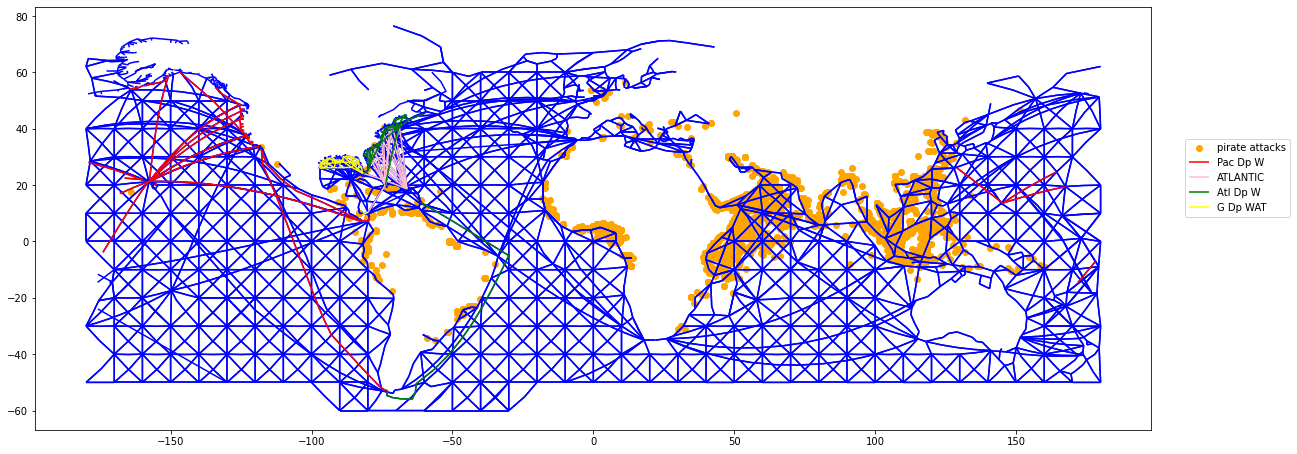

In [240]:
# Plotting
fig, ax = plt.subplots(figsize=(20, 20))
gpf.plot(color='blue', ax=ax)
random_colours = ["red", "pink", "green", "yellow"]
point_gdf = gpd.GeoSeries(pirate_attack_points)
point_gdf.plot(ax=ax, color="orange", label="pirate attacks")
counter = 0
for route_name, pathway in all_linestring_of_top_route.items():
    line_gdf = gpd.GeoSeries(pathway)
    line_gdf.plot(ax=ax, color=random_colours[counter], label=route_name)
    counter+=1
fig.legend(loc="lower right", bbox_to_anchor=(1, 0.5))


### Runner

In [58]:
def sequential_deduplication(func: Iterator[str]) -> Iterator[str]:
    '''
    Decorator that doesn't permit two consecutive items to be the same
    '''
    def inner(*args):
        iterable = func(*args)
        last = None
        while (cell := next(iterable, None)) is not None:
            if cell != last:
                yield cell
            last = cell
    return inner

@sequential_deduplication
def h3polyline(line: Union[LineString, MultiLineString], resolution: int) -> Iterator[str]:
    '''
    Iterator yeilding H3 cells representing a (multi)line,
    retaining order and self-intersections
    '''
    if line.geom_type == 'MultiLineString':
        # Recurse after getting component linestrings from the multiline
        for l in map(lambda geom: h3polyline(geom, resolution), line.geoms):
            yield from l
    else:
        coords = zip(line.coords, line.coords[1:])
        while (vertex_pair := next(coords, None)) is not None:
            i, j = vertex_pair
            a = h3.geo_to_h3(*i[::-1], resolution)
            b = h3.geo_to_h3(*j[::-1], resolution)
            yield from h3.h3_line(a, b) # inclusive of a and b

In [243]:
## Martime lines. Would need to create martime routes via lines <-- Updated map can get better resolution if needed
gdf_gpkg = gp.read_file("../.data/marnet_plus_10km.gpkg")
gdf_gpkg.info

<bound method DataFrame.info of        pass                                           geometry
0      None  LINESTRING (-4.90308 50.09092, -4.82944 50.08106)
1      None    LINESTRING (8.45456 54.28094, 8.37666 54.22969)
2      None  LINESTRING (-130.66800 53.74350, -130.75800 53...
3      None  LINESTRING (12.65350 44.77300, 12.64100 44.88350)
4      None  LINESTRING (-123.05200 48.85550, -123.00600 48...
...     ...                                                ...
48296  None  LINESTRING (-68.94550 12.10150, -69.03850 12.0...
48297  None  LINESTRING (-115.00000 15.17050, -112.54950 12...
48298  None  LINESTRING (-66.11400 18.46250, -66.12750 18.4...
48299  None  LINESTRING (13.96400 44.31275, 13.88650 44.29144)
48300  None  LINESTRING (30.46075 70.01500, 30.94350 70.22350)

[48301 rows x 2 columns]>

In [ ]:
# Plotting
plot_lines = gpd.GeoSeries(gdf_gpkg["geometry"].tolist())
fig, ax = plt.subplots(figsize=(20, 20))
gdf_gpkg.plot(color='blue', ax=ax)

## Raster to H3

In [38]:
import rasterio as rst
from rasterio.plot import show
import h3.api.numpy_int as h3
from rasterio.profiles import DefaultGTiffProfile
import numpy as np

In [41]:
# src = rst.open('../.data/shipdensity_global.tif', **DefaultGTiffProfile(count=3))
src = rst.open('../.data/shipping.tif', **DefaultGTiffProfile(count=3))
print(src.colorinterp)
# print(src.read(1).shape)
grey = src.read(1)

(<ColorInterp.gray: 1>,)


In [42]:
## Explore data

# print(src.crs)
# print(src.shape)
# print(src.bounds)
# print(src.count)
print(src.profile)
# print(src.read_masks(1))
# print(grey.min())
# print(grey.max())
# print(grey.mean())

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028230607370965e+38, 'width': 38610, 'height': 19305, 'count': 1, 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Mollweide"],PARAMETER["central_meridian",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(934.4788770112186, 0.0, -18040095.196131725,
       0.0, -934.478877011219, 9020047.348069983), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


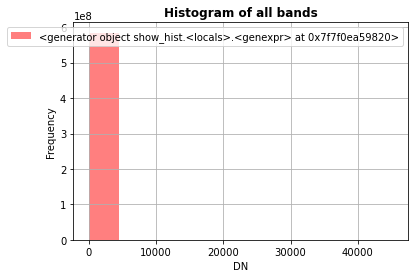

In [43]:
from rasterio.plot import show_hist

show_hist(source=src, bins=10, title='Histogram of all bands', histtype='stepfilled', alpha=0.5)

In [20]:
# Create mask to reduce size of raster
major = (grey > 10000) & (grey < 20000)
standard = (grey > 500) & (grey < 9999)
minor = (grey < 500)

reduced_map = np.full(grey.shape, 10000, dtype="int8")

65468393

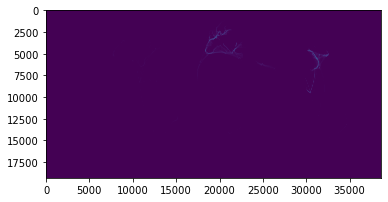

<AxesSubplot:>

In [44]:
norm = (grey * (255 / np.max(grey))).astype(np.uint8)
show(norm)